In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

# Preprocess HASLAM map as it is done for Synchrotron Amplitude template

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

nside = 512
lmax = 3 * nside
comp = "IQU"
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [5]:
datadir = Path("data")
imapfile = datadir / "haslam408_dsds_Remazeilles2014.fits"
qumapfile = datadir / "wmap_band_iqumap_r9_9yr_K_v5.fits"
if not imapfile.exists():
    !wget -O $imapfile   https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits
if not qumapfile.exists():
    !wget -O $qumapfile   https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/wmap_band_iqumap_r9_9yr_K_v5.fits
imap = hp.read_map(imapfile)
qumap = hp.read_map(qumapfile, field=[1, 2])

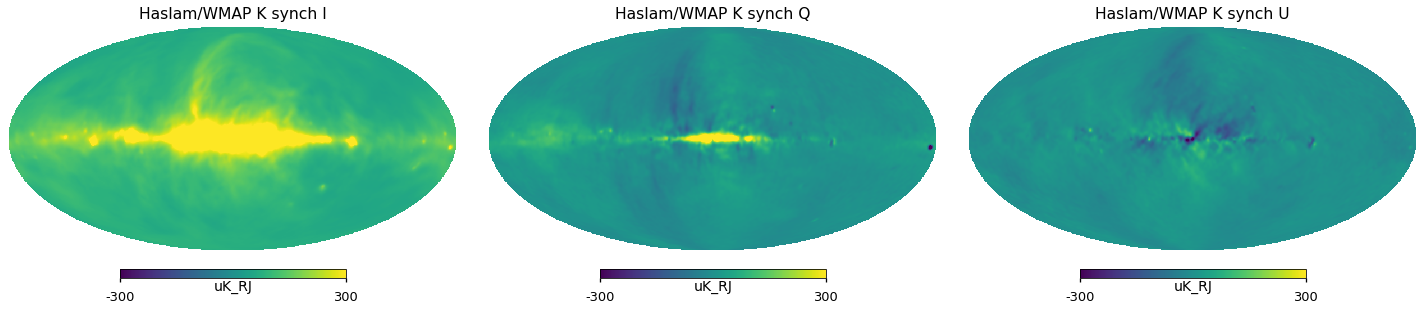

In [6]:
rescaling_factor = (23.0 / 0.408) ** -3.1

imap *= rescaling_factor
imap <<= u.K_RJ
imap = imap.to(u.uK_RJ)
qumap <<= u.mK_RJ
qumap = qumap.to("uK_RJ")
IQU = np.array([imap, qumap[0], qumap[1]])
FWHM_SMOOTHING = 2  # deg
IQU = hp.smoothing(IQU, fwhm=np.radians(FWHM_SMOOTHING))
IQU <<= u.uK_RJ
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        IQU[i_pol],
        title="Haslam/WMAP K synch " + pol,
        sub=131 + i_pol,
        unit=IQU.unit,
        min=-300,
        max=300,
    )

In [7]:
from pysm3.utils import map_to_log_pol_tens

iqu = map_to_log_pol_tens(IQU.value)

In [8]:
datadir = Path("data")

In [9]:
output_dir = Path("production-data/synch")

In [10]:
output_nside = 2048

In [11]:
output_lmax = 2 * output_nside
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[0] = 1

In [12]:
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)
for i in range(3):
    iqu[i, np.isnan(iqu[i])] = np.nanmedian(iqu[i])
assert np.isnan(iqu).sum() == 0
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)

527 pixels out of 3145728 are NaNs in Log Pol Tens maps 
0 pixels out of 3145728 are NaNs in Log Pol Tens maps 


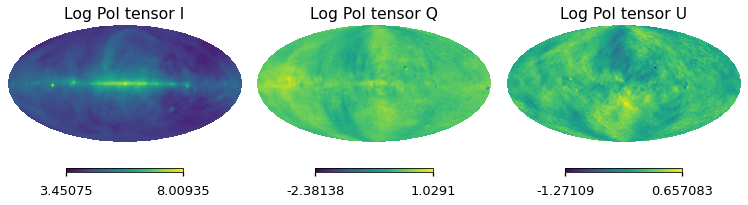

In [13]:
for i_pol, pol in components:
    hp.mollview(iqu[i_pol], title="Log Pol tensor " + pol, sub=131 + i_pol)

### Template for $C_s$ is the $i$ map smoothed at 5deg 

The modulation amplitude is exactly the same as the one adopted for $\beta_s$  and $intensity $ small scales 

In [14]:
ismooth = hp.smoothing(iqu[0], fwhm=np.radians(5))
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

modulate_amp = (ismooth) * 1.0

mskmd = ismooth > 5.5
b1 = 1.5
a = 0.5

mskmd = ismooth > 5

modulate_amp[mskmd] = minmax(ismooth[mskmd], 1.1, 2)
modulate_amp[~mskmd] = minmax(ismooth[~mskmd], 0.1, 1.1)

### Tweak the values for MinMax rescaling so that we match Kogut 2012 measurements within ARCADE patch 

In [15]:
Cmap = minmax(ismooth, a=-0.041, b=-0.076)

### Load ARCADE patch 
make wget link 

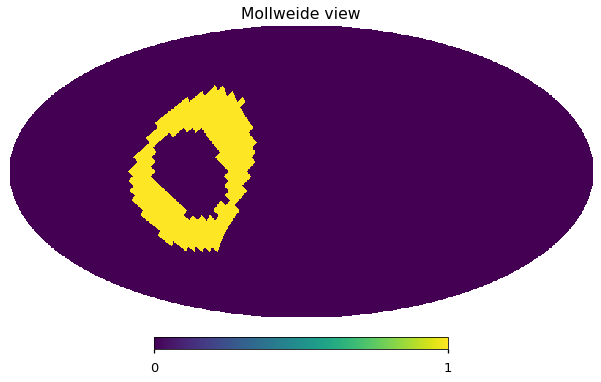

In [16]:
arcadefile = datadir / "arc2_3150_v19.fits"
if not arcadefile.exists():
    !wget -O $arcadefile   https://lambda.gsfc.nasa.gov/data/suborbital/ARCADE/arc2_3150_v19.fits

arcade = hp.read_map(arcadefile)
mask = arcade != 0
mask_arcade = hp.ud_grade(mask, nside_out=hp.get_nside(Cmap))
hp.mollview(mask_arcade)

In [17]:
print(
    f" Kogut 2012 measured Cs = -0.052\pm 0.005, we get within ARCADE patch:\n"
    + f"{Cmap[mask_arcade].mean():.4f}\pm { Cmap[mask_arcade] .std():.4f}"
)

 Kogut 2012 measured Cs = -0.052\pm 0.005, we get within ARCADE patch:
-0.0517\pm 0.0054


/tmp/ipykernel_43217/3364598603.py:2: RuntimeWarning: invalid value encountered in true_divide
  (Cmap * mask_arcade) / mask_arcade,
0.0 180.0 -180.0 180.0


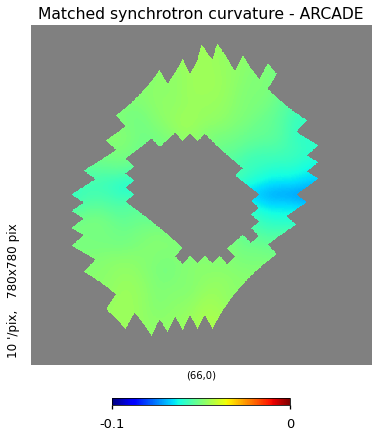

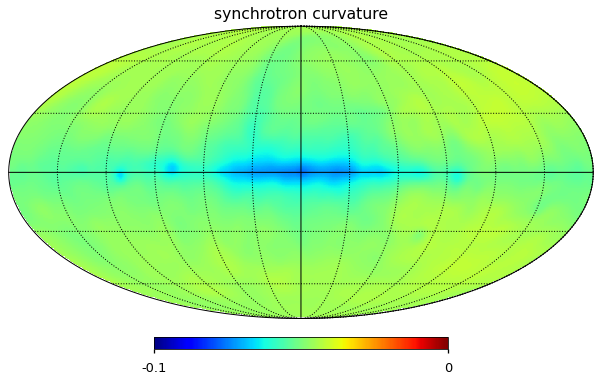

In [18]:
hp.gnomview(
    (Cmap * mask_arcade) / mask_arcade,
    title="Matched synchrotron curvature - ARCADE",
    rot=[66, 0],
    reso=10,
    xsize=780,
    cmap="jet",
    min=-0.1,
    max=0,
)

hp.mollview(Cmap, title="synchrotron curvature", cmap="jet", min=-0.1, max=0)
hp.graticule()

# Inject  Modulated small scales to  $C_s$ 

In [19]:
ell = np.arange(lmax + 1)
cl_spass_fit = 10 ** (-0.82655497) * ell ** (-2.60860208)
cl_spass_fit[0] = 0
ell_fit_low = 10
ell_fit_high = 36

/tmp/ipykernel_43217/1537673065.py:2: RuntimeWarning: divide by zero encountered in power
  cl_spass_fit = 10 ** (-0.82655497) * ell ** (-2.60860208)


In [20]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [21]:
ell, cl_norm, cl_c = run_anafast(Cmap, lmax=lmax)

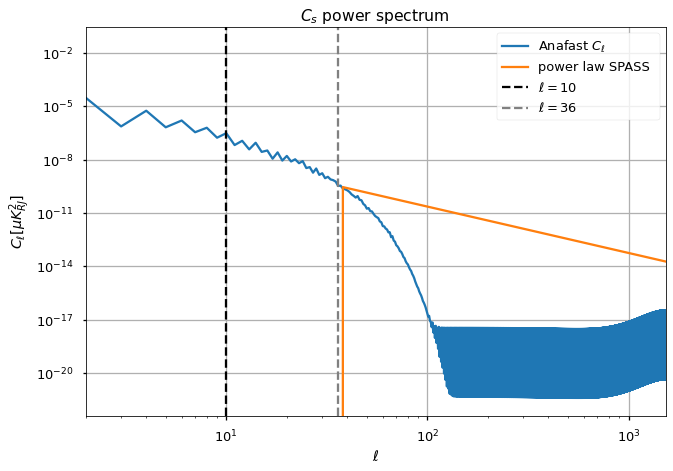

In [22]:
gamma_spass = -2.60860208
A0 = cl_c["TT"][ell_fit_high] / ell_fit_high ** (gamma_spass)

if output_nside < 4096:

    plt.loglog(ell, cl_c["TT"], label="Anafast $C_\ell$")
    plt.plot(
        ell[ell_fit_high:],
        model(ell[ell_fit_high:], A0, gamma_spass),
        label="power law SPASS ",
    )

    plt.axvline(
        ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low)
    )
    plt.axvline(
        ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high)
    )
    plt.grid()
    plt.title(r"$C_s  $" + f" power spectrum ")
    plt.legend()
    plt.ylabel("$ C_\ell [\mu K_{RJ}^2]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)

In [23]:
from pysm3.utils import add_metadata, sigmoid

In [24]:
sig_func = sigmoid(output_ell, x0=ell_fit_high, width=20)
np.random.seed(777)
alm_Cs = hp.map2alm(Cmap, lmax=lmax, use_pixel_weights=True)
Cs_ls_alm = hp.almxfl(alm_Cs, np.sqrt(1.0 - sig_func))
Cs_ss_alm = hp.synalm(model(output_ell, A0, gamma_spass), lmax=output_lmax)
Cs_ss_alm = hp.almxfl(Cs_ss_alm, np.sqrt(sig_func))
Cs_ss = hp.alm2map(Cs_ss_alm, lmax=output_lmax, nside=output_nside)
Cs_ss *= hp.ud_grade(modulate_amp, output_nside)

Cs_ls = hp.alm2map(Cs_ls_alm, nside=output_nside)
Cs_out = Cs_ss + Cs_ls
ell, _, clcs_out = run_anafast(Cs_out, lmax=lmax)
ell, _, clls = run_anafast(Cs_ls, lmax=lmax)
ell, _, clss = run_anafast(Cs_ss, lmax=lmax)

/tmp/ipykernel_43217/1065277110.py:13: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


In [25]:
output_map_alm = hp.map2alm(Cs_out, lmax=output_lmax)

In [26]:
if output_nside > 4096:

    hp.write_alm(
        output_dir / "raw" / f"synch_curvature_alm_nside{output_nside}_lmax{output_lmax}_complex64.fits",
        output_map_alm,
        out_dtype = np.complex64,
        overwrite=True,
    )
    add_metadata([output_dir / "raw" / f"synch_curvature_alm_nside{output_nside}_lmax{output_lmax}_complex64.fits"], coord="G", unit="", ref_freq="23 GHz")

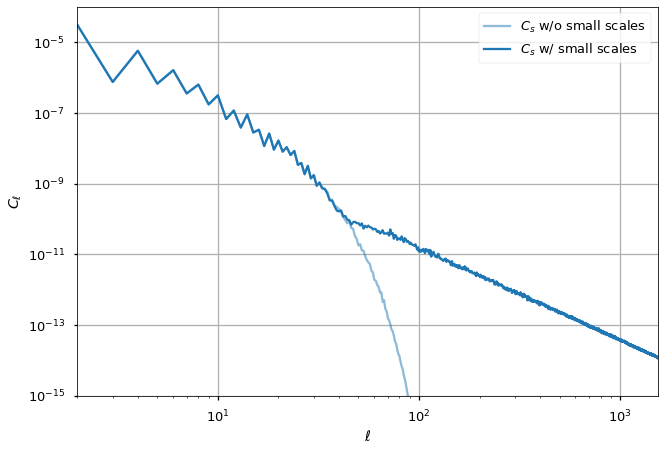

In [27]:
if output_nside < 4096:

    for ii in range(1):
        plt.loglog(
            ell, cl_c["TT"], alpha=0.5, color="C%d" % ii, label=r"$ C_s$ w/o small scales"
        )
        plt.loglog(
            ell,
            clcs_out["TT"],
            label=r"$  C_s$ w/ small scales ",
        )
        # plt.loglog(ell,  clls[pol], label=r"$  \beta_s$ PySM3 ",  )
        # plt.loglog(ell,  clss[pol], label=r"$  \beta_s$ PySM3 ",  )

        plt.grid(True)

        plt.legend()

        plt.ylabel("$ C_\ell $")
        plt.xlabel(("$\ell$"))
        # plt.xlim(10, 55 )
        plt.xlim(2, lmax)
    plt.ylim(1e-15, 1e-4)

In [28]:
mask_arcade_high_nside = hp.ud_grade(mask_arcade, output_nside).astype(np.bool)

/tmp/ipykernel_43217/3137707393.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_arcade_high_nside = hp.ud_grade(mask_arcade, output_nside).astype(np.bool)


/tmp/ipykernel_43217/3357961219.py:4: RuntimeWarning: invalid value encountered in true_divide
  (Cmap * mask_arcade) / mask_arcade,
/tmp/ipykernel_43217/3357961219.py:15: RuntimeWarning: invalid value encountered in true_divide
  (Cs_out * mask_arcade_high_nside) / mask_arcade_high_nside,
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


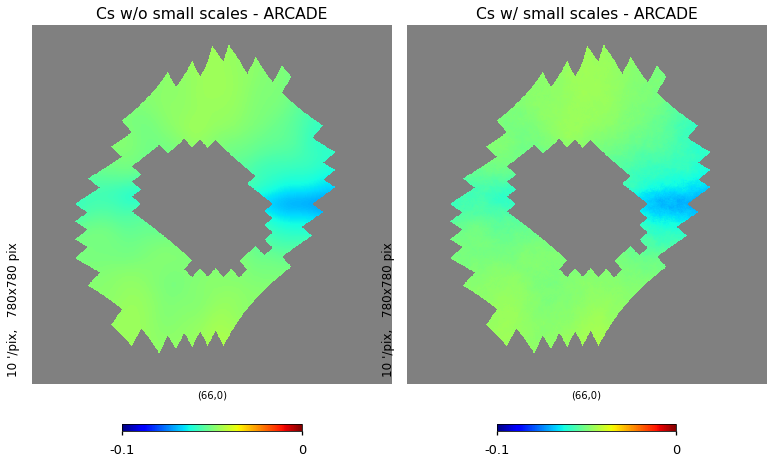

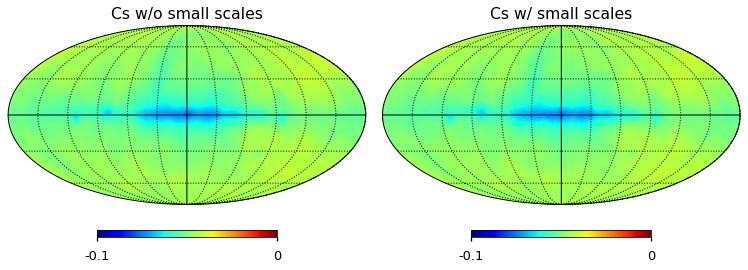

In [29]:
if output_nside < 4096:

    hp.gnomview(
        (Cmap * mask_arcade) / mask_arcade,
        title="Cs w/o small scales - ARCADE",
        rot=[66, 0],
        reso=10,
        sub=121,
        xsize=780,
        cmap="jet",
        min=-0.1,
        max=0,
    )
    hp.gnomview(
        (Cs_out * mask_arcade_high_nside) / mask_arcade_high_nside,
        title="Cs w/ small scales - ARCADE",
        rot=[66, 0],
        reso=10,
        sub=122,
        xsize=780,
        cmap="jet",
        min=-0.1,
        max=0,
    )
    plt.figure()
    hp.mollview(Cmap, title="Cs w/o small scales", cmap="jet", min=-0.1, max=0, sub=121)


    hp.mollview(Cs_out, title="Cs w/ small scales", cmap="jet", min=-0.1, max=0, sub=122)
    hp.graticule()

In [30]:
print(
    f" Kogut 2012 measured Cs = -0.052\pm 0.005, we get within ARCADE patch:\n"
    + f"{Cs_out[mask_arcade_high_nside].mean().mean():.4f}\pm { Cs_out[mask_arcade_high_nside]  .std():.4f}"
)

 Kogut 2012 measured Cs = -0.052\pm 0.005, we get within ARCADE patch:
-0.0517\pm 0.0054
